## ACES-3: Solutions

In [1]:
# Importing everything we need for all three notebooks.
import os.path
import pickle
import h5py
import requests

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import LambdaCDM
from astropy.cosmology import Planck18 as cosmo

from unyt import Gyr, Myr, kpc, K

from synthesizer.filters import FilterCollection
from synthesizer.particle import Stars, Galaxy
from synthesizer.grid import Grid
from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000
from synthesizer.emission_models.attenuation.igm import Inoue14
from synthesizer.emission_models.dust.emission import Greybody

import bagpipes as pipes
# Change this to 'nautilus' if required.
sampler = 'multinest'    
import corner

Bagpipes: Latex distribution not found, plots may look strange.


In [2]:
# Function for making a corner plot with true values indicated.
def make_corner(samples, truth, labels, titles):

    # Make the corner plot.
    fig= corner.corner(samples, labels=labels, titles = titles,quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 10},
                        smooth=1., smooth1d=1., bins=25)

    # Add lines to plot indicating the true value.
    axes = np.arange(0, len(labels)**2, len(labels)+1)
    for value, axis in zip(truth,axes):
        fig.axes[axis].axvline(value, color = 'red', linestyle = ':',label = 'Truth')
        fig.axes[0].legend()

    plt.show()
    plt.close(fig)

### Bagpipes SED Fitting

---

We can start by including some HST filters to get better coverage of the Lyman break. We just need to select the corresponding filters from the table and add the transmission curve paths to the list. We can then use an identical fitting approach.

In [3]:
# Load the photometry table and sort by wavelength.
gnz11 = Table.read('../gnz11_photometry.fits')
gnz11.sort('pivot')

In [4]:
# Now including two ACS filters, for better coverage of the Lyman break.
filters = [f'HST/ACS_WFC.{f}' for f in ['F606W', 'F814W']] + [f'JWST/NIRCam.{f}' for f in ['F115W', 'F150W','F200W', 'F277W', 'F335M', 'F356W', 'F410M','F444W']]

# Paths to filter transmission files.
jwst_acs_filters = ["filters/HST_ACS_WFC.F606W.dat", "filters/HST_ACS_WFC.F814W.dat", 
                     "filters/JWST_NIRCam.F115W.dat", "filters/JWST_NIRCam.F150W.dat",
                     "filters/JWST_NIRCam.F200W.dat", "filters/JWST_NIRCam.F277W.dat",
                     "filters/JWST_NIRCam.F335M.dat", "filters/JWST_NIRCam.F356W.dat",
                     "filters/JWST_NIRCam.F410M.dat", "filters/JWST_NIRCam.F444W.dat"]

# Dummy function for passing fluxes and errors to Bagpipes.
def load_data(ID, gnz11 = gnz11, filters = filters):

    mask = [f in filters for f in gnz11['filter']]

    photometry = np.c_[gnz11[mask]['flux']/1e3, gnz11[mask]['error']/1e3]

    return photometry

In [5]:
# Using the same fitting approach.
fit_info = {}   

fit_info["redshift"] = (0,20)    # Observed redshift.

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Assume an constant SFH.
constant = {}
constant["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
constant["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

constant["age_max"] = (0, float(cosmo.age(0).value))    # Time since SF switched on. [Gyr]
constant["age_min"] = (0, float(cosmo.age(0).value))    # Time since SF switched off. [Gyr]

fit_info['constant'] = constant

# Nubular.
nebular = {}
nebular["logU"] = (-4,-2)    # Log of the ionization parameter. 
fit_info["nebular"] = nebular

In [6]:
# Create the bagpipes galaxy and fit.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_acs_filters, spectrum_exists=False)

fit = pipes.fit(bp_galaxy, fit_info, run = 'gnz11_jwst_acs')
fit.fit(verbose=False, sampler = sampler)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the pr

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


Including F606W and F814W still leads to a low-redshift, quiesent solution. This tells us that wavelength coverage is not the issue here.

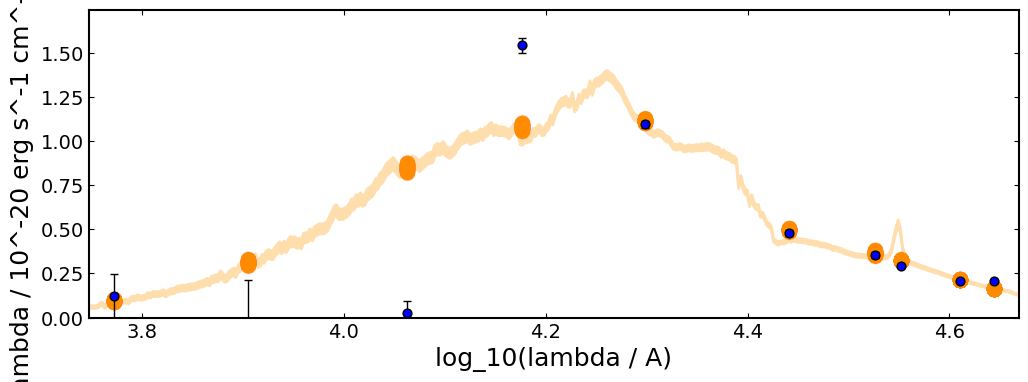

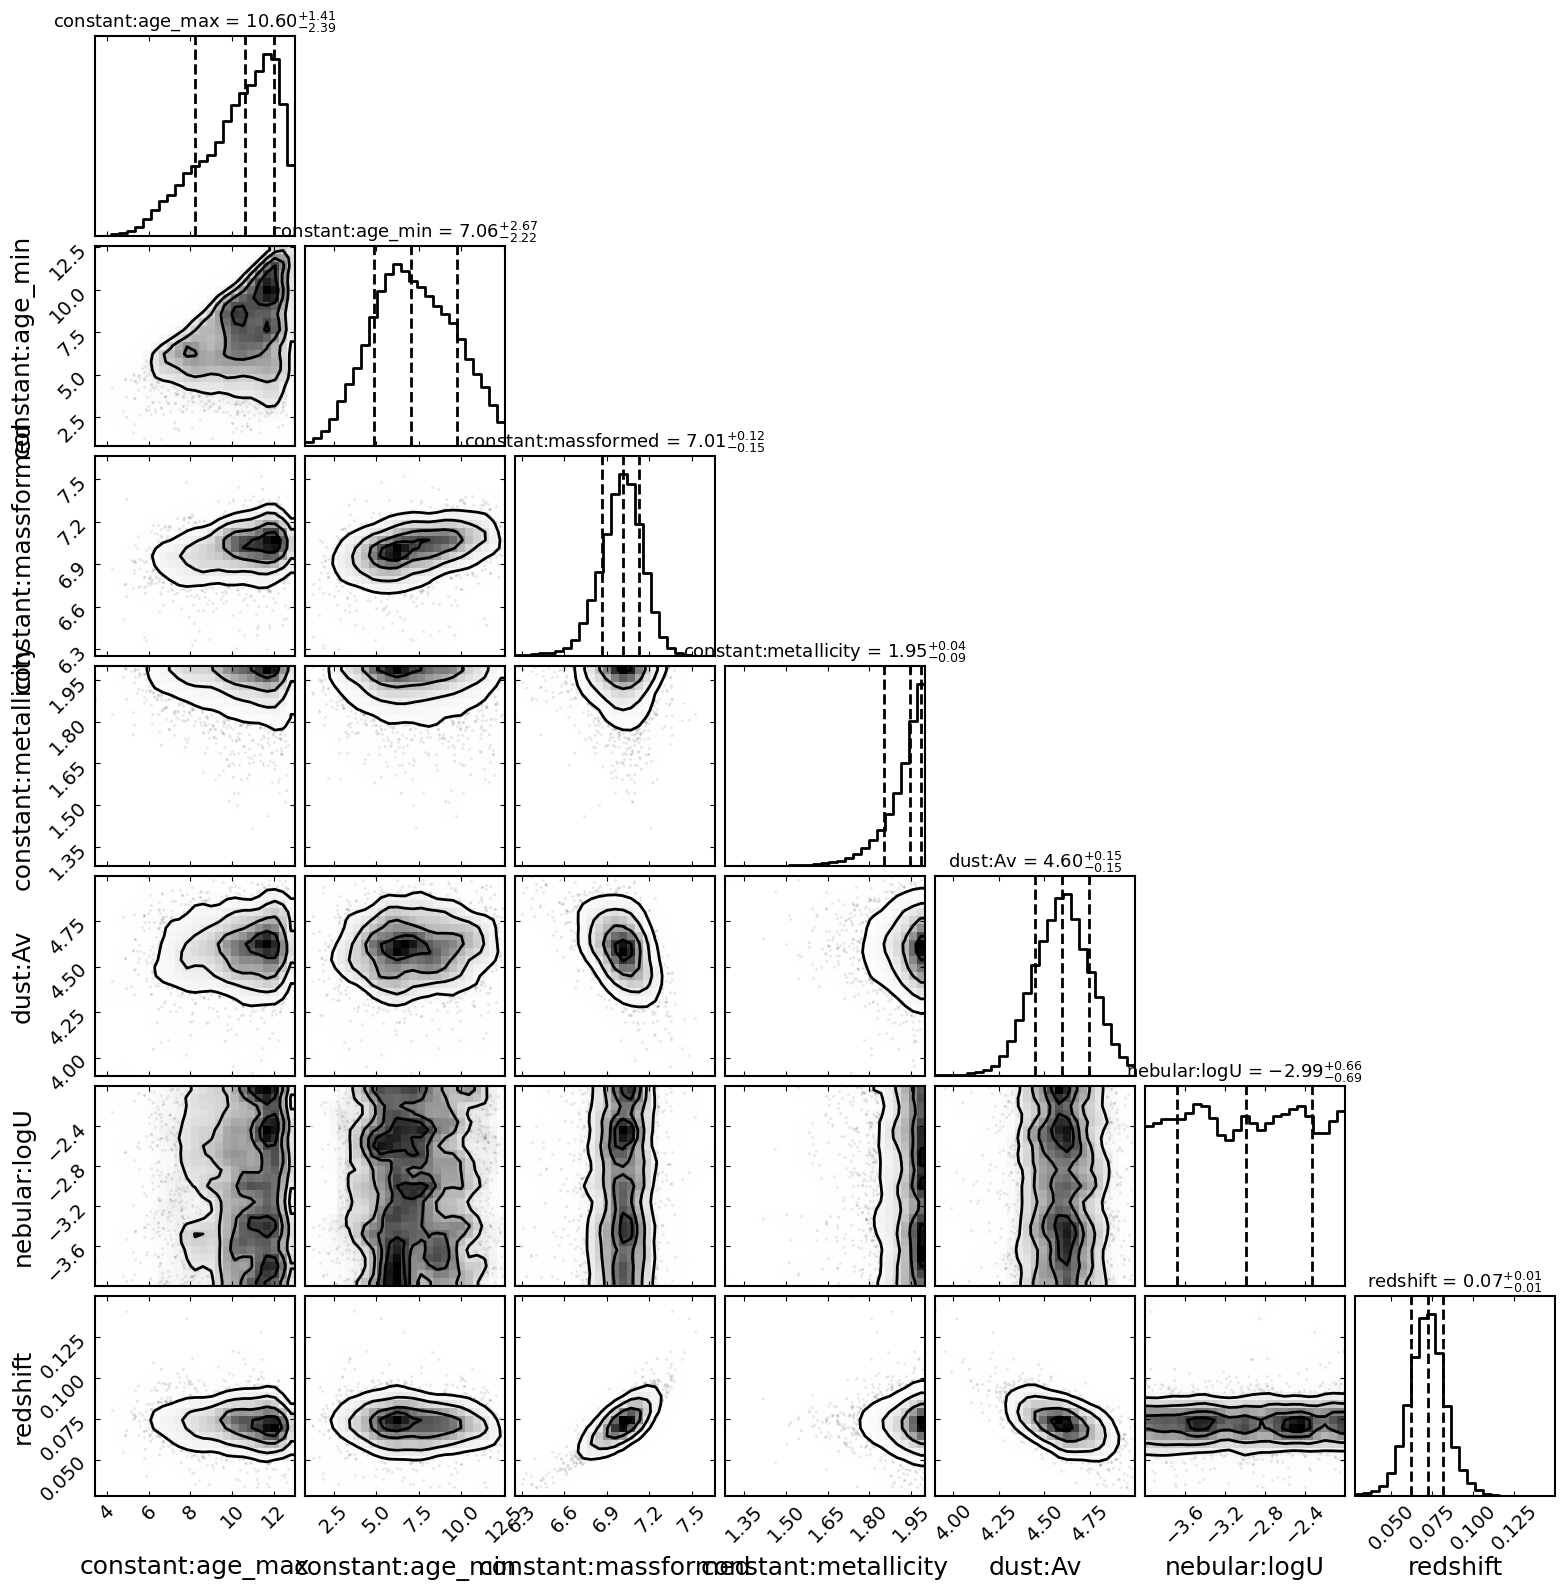

In [7]:
# Plot the spectrum and corner.
fit.plot_spectrum_posterior(save=False, show=True)
fit.plot_corner()

Let's trying changing the model we're fitting. A constant SFH is probably not very physical in the early stages of galaxy evolution as star formation is likely ramping up. Let's use an exponential and go back to the original filter set.

In [8]:
# Using just the JWST filters again.
filters = [f'JWST/NIRCam.{f}' for f in ['F115W', 'F150W', 'F200W', 'F277W', 'F335M', 'F356W',
                                        'F410M', 'F444W']]

# Paths to filter transmission files.
jwst_filters = ["filters/JWST_NIRCam.F115W.dat", "filters/JWST_NIRCam.F150W.dat",
                     "filters/JWST_NIRCam.F200W.dat", "filters/JWST_NIRCam.F277W.dat",
                     "filters/JWST_NIRCam.F335M.dat", "filters/JWST_NIRCam.F356W.dat",
                     "filters/JWST_NIRCam.F410M.dat", "filters/JWST_NIRCam.F444W.dat"]

# Define the dummy function for passing fluxes and errors to Bagpipes.
def load_data(ID, gnz11 = gnz11, filters = filters):

    mask = [f in filters for f in gnz11['filter']]

    # Convert from nJy to uJy.
    photometry = np.c_[gnz11[mask]['flux']/1e3, gnz11[mask]['error']/1e3]

    return photometry

In [9]:
# Changing to an exponential SFH.
fit_info = {}   

fit_info["redshift"] = (0, 20)    # Observed redshift.

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0, 5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Define an exponential SFH.
exponential = {}
exponential["massformed"] = (5, 13)    # Log of total stellar mass formed. [Msol]
exponential["metallicity"] = (1e-4, 1)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

exponential["tau"] = (-5, 5)    # Timescale of exponential change. [Gyr] 
exponential["age"] = (0, float(cosmo.age(0).value))    # Time since SF began. [Gyr]

fit_info["exponential"] = exponential

# Nubular.
nebular = {}
nebular["logU"] = (-4, -2)    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

In [10]:
# Create the bagpipes galaxy and fit.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_filters, spectrum_exists=False)

fit = pipes.fit(bp_galaxy, fit_info, run = 'gnz11_jwst_exp')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************

Completed in 129.4 seconds.
 ln(ev)=   370.09741785254113      +/-  0.20702736158534879     
 Total Likelihood Evaluations:       144608
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.149      0.226      0.285
exponential:age                0.067      0.108      0.165
exponential:massformed         9.222      9.390      9.533
exponential:metallicity        0.005      0.030      0.089
exponential:tau               -3.101     -0.399      3.321
nebular:logU              

The fitted spectrum looks good and the redshift matches the spectroscopic value within $1 \sigma$. However, I'm not sure we can trust the infered parameters, as the contours do not look converged. We could potentialy improve this by increasing the number of points used for fitting, but this would slow us down.

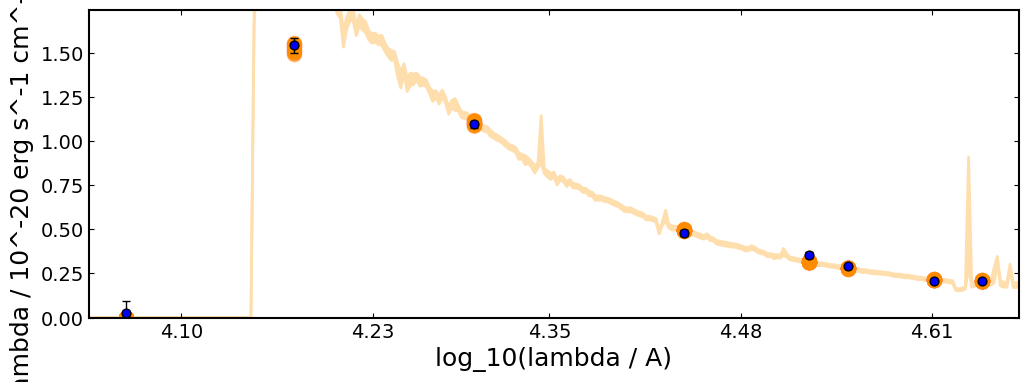

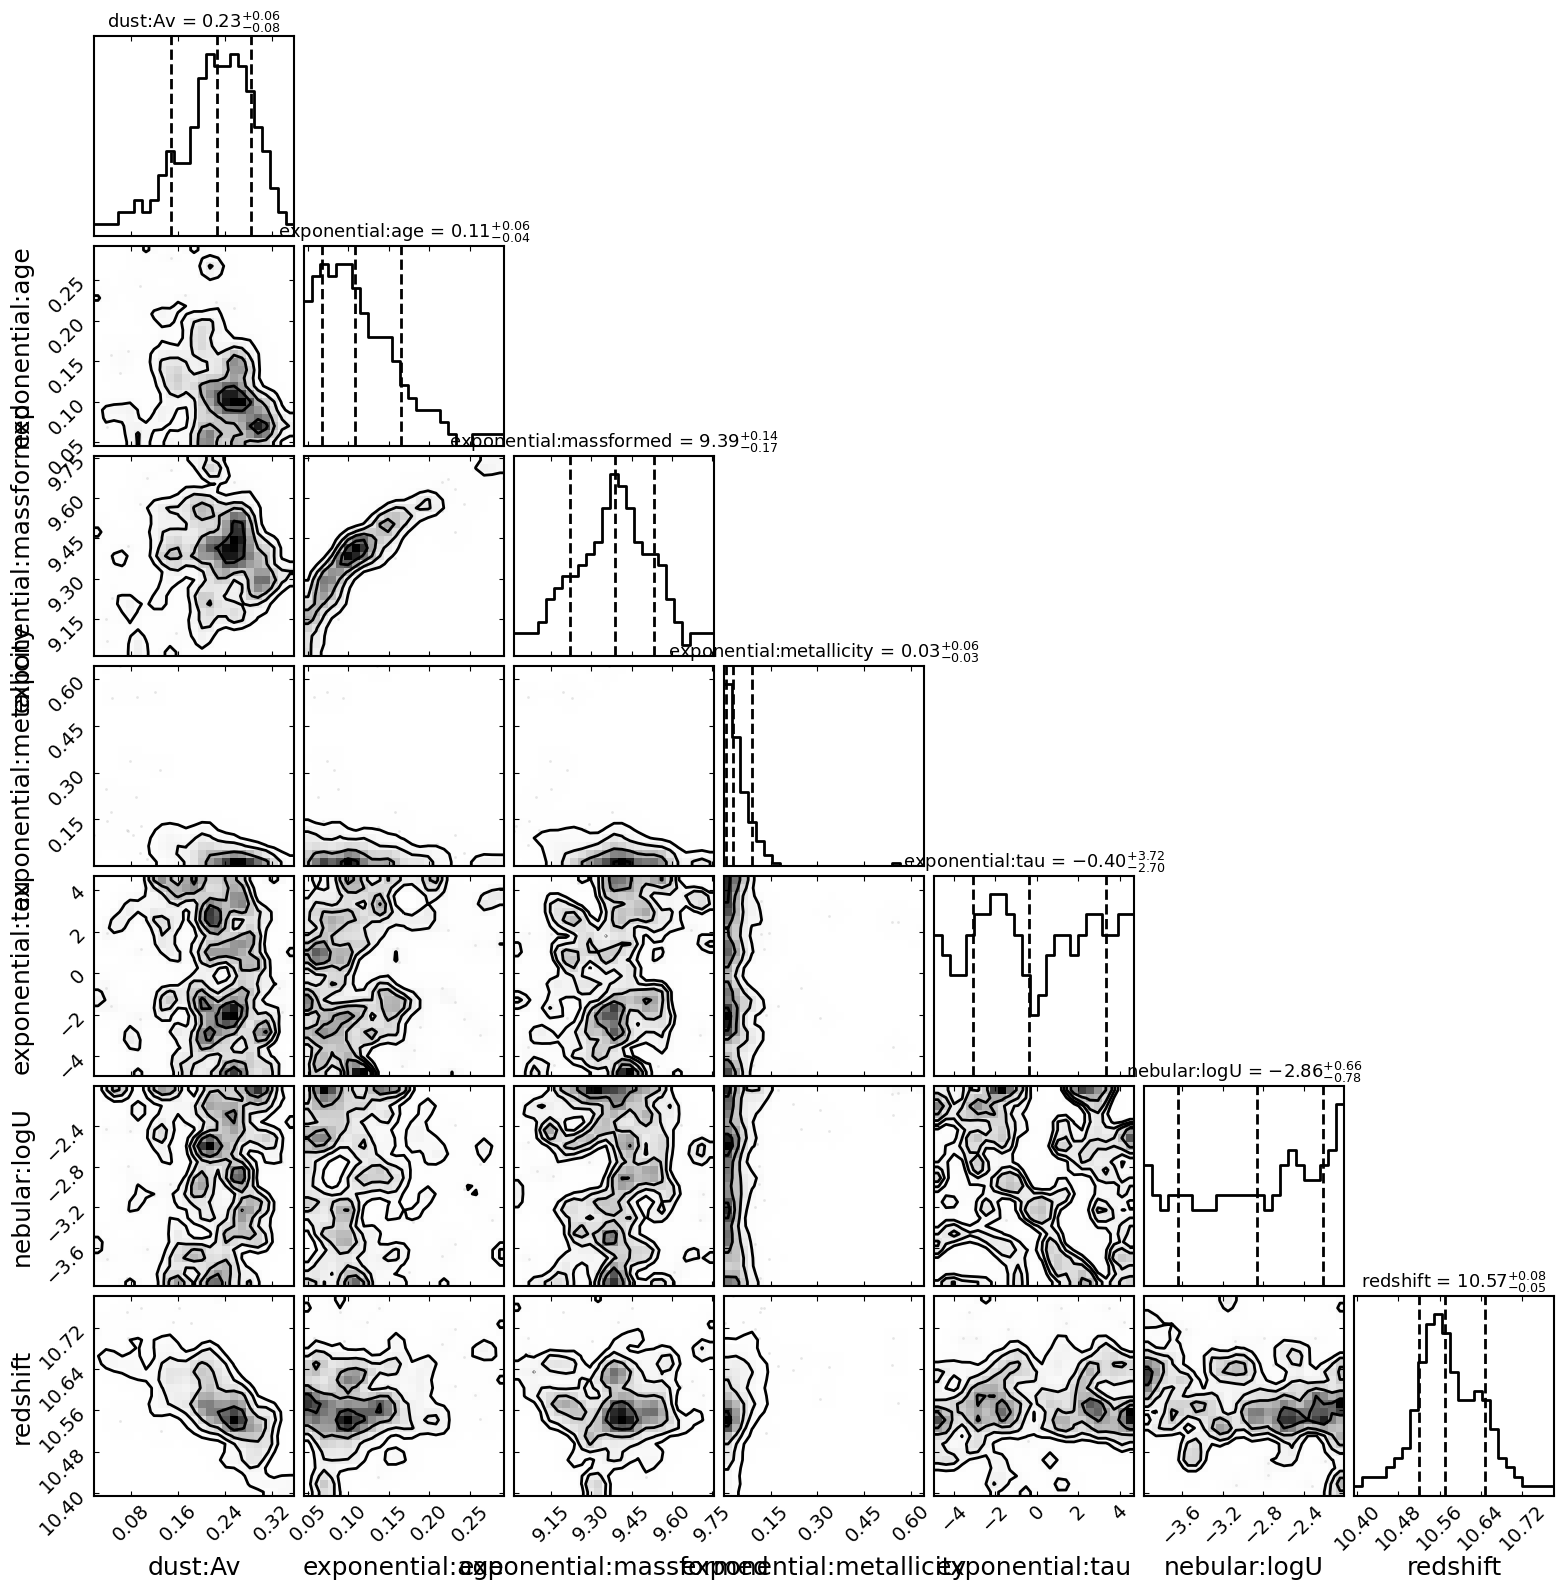

In [11]:
# Plot the spectrum and corner.
fit.plot_spectrum_posterior(save=False, show=True)
fit.plot_corner()

### Forward Modelling with Synthesizer

---

Getting the galaxy. This is all copied from the notebook.

In [12]:
#---------------------------------------------------------------------
api_key = "c37483fea84b70f4ad9f777c38357ea0"    # Your TNG-API key.
data_path = '../data'    # Relative path to simulation data directory.
#---------------------------------------------------------------------

headers = {"api-key":api_key}

In [13]:
# Function for fetching simulation data from the TNG API.
def get(path, data_path, headers, params=None):

    # Make HTTP GET request to path.
    r = requests.get(path, params=params, headers=headers)

    # Raise exception if response code is not HTTP SUCCESS (200).
    r.raise_for_status()

    # Parse json responses automatically.
    if r.headers['content-type'] == 'application/json':
        return r.json() 

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(f'{data_path}/'+filename, 'wb') as f:
            f.write(r.content)
        return filename

    return r

In [14]:
# URL of the chosen simulation.
baseUrl = 'http://www.tng-project.org/api/TNG50-1/'

# Query for simulation properties.
sim = get(baseUrl, data_path, headers=headers)
for k, v in sim.items():
    print(f'{k}: {v}')

name: TNG50-1
description: Main high-resolution IllustrisTNG50 run including the full TNG physics model.
name_alt: L35n2160TNG
boxsize: 35000.0
z_start: 127.0
z_final: 0.0
cosmology: Planck2015
omega_0: 0.3089
omega_L: 0.6911
omega_B: 0.0486
hubble: 0.6774
physics_model: Fiducial TNG Model
has_cooling: True
has_starformation: True
has_winds: True
has_blackholes: True
mass_gas: 5.73879e-06
mass_dm: 3.07367708626464e-05
softening_dm_comoving: 0.39
softening_stars_comoving: 0.39
softening_blackholes_comoving: 0.39
softening_gas_comoving: 0.39
softening_dm_max_phys: 0.195
softening_stars_max_phys: 0.195
softening_blackholes_max_phys: 0.39
softening_gas_max_phys: 0.195
softening_gas_factor: 2.5
softening_gas_comoving_min: 0.05
num_dm: 10077696000
num_tr_mc: 10077696000
num_tr_vel: 0
longids: True
is_uniform: True
is_zoom: False
is_subbox: False
num_files_snapshot: 680
num_files_groupcat: 680
num_files_rockstar: 0
num_files_lhalotree: 200
num_files_sublink: 11
num_files_ctrees: 0
filesize_lh

In [15]:
# Define a LambdaCDM cosmology using parameters from the simulation.
Om0 = sim['omega_0']
Ob0 = sim['omega_B']
Ode0 = sim['omega_L']
h = sim['hubble']
H0 = h * 100 

cosmo = LambdaCDM(Om0=Om0, Ode0=Ode0, H0=H0, Ob0=Ob0)

# Create a dictionary of snapshots and redshifts.
snapshots = get(sim['snapshots'], data_path, headers)
snapshot_redshifts = {snapshot['number']: snapshot['redshift'] for snapshot in snapshots}

In [16]:
#---------------------------------------------------------
id = '145492'    # The ID of the galaxy you wish to image.
redshift = 2    # The redshift snapshot to use.
#---------------------------------------------------------

# The data url for the object of interest.
url = f"{baseUrl}/snapshots/z={str(redshift)}/subhalos/{str(id)}"

In [17]:
# We will need the coordinates, metallicity, age, and initial mass of
# all the star particles.
params = {'stars':'Coordinates,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass'}

# Download the subhalo properties and save them as a pickle file.
subhalo_properties_filename = f'{data_path}/subhalo_properties_{id}.pkl'
if not os.path.isfile(subhalo_properties_filename):
    subhalo_properties = get(url, data_path, headers)
    pickle.dump(subhalo_properties, open(subhalo_properties_filename,'wb'))

# Download the HDF5 cutout for the galaxy.
cutout_filename = f'{data_path}/cutout_{id}.hdf5'
if not os.path.isfile(cutout_filename):
    get(url + "/cutout.hdf5", data_path, headers, params)

In [18]:
# Display the galaxy properties,
subhalo_properties = pickle.load(open(f'{data_path}/subhalo_properties_{id}.pkl','rb'))
for k,v in subhalo_properties.items():
    print(f'{k}: {v}')

# and the exact snapshot redshift.
snapshot_redshift = snapshot_redshifts[subhalo_properties['snap']]
print(f'snapshot redshift: {snapshot_redshift}')

snap: 33
id: 145492
bhmdot: 0.00214158
cm_x: 2631.63
cm_y: 22423.6
cm_z: 32813.0
gasmetallicity: 0.0234775
gasmetallicityhalfrad: 0.0332981
gasmetallicitymaxrad: 0.0139534
gasmetallicitysfr: 0.0156152
gasmetallicitysfrweighted: 0.0216725
pos_x: 2614.18
pos_y: 22429.6
pos_z: 32811.7
halfmassrad: 71.0307
halfmassrad_gas: 67.2129
halfmassrad_dm: 75.0715
halfmassrad_stars: 7.5072
halfmassrad_bhs: 0.0
len: 2303786
len_gas: 793943
len_dm: 1201183
len_stars: 308659
len_bhs: 1
mass: 43.4305
mass_gas: 5.0807
mass_dm: 36.9205
mass_stars: 1.42703
mass_bhs: 0.002327
massinhalfrad: 2.0413
massinhalfrad_gas: 0.196656
massinhalfrad_dm: 1.12881
massinhalfrad_stars: 0.713511
massinhalfrad_bhs: 0.002327
massinmaxrad: 12.493
massinmaxrad_gas: 1.64067
massinmaxrad_dm: 9.48976
massinmaxrad_stars: 1.36023
massinmaxrad_bhs: 0.002327
massinrad: 4.61426
massinrad_gas: 0.622574
massinrad_dm: 2.90797
massinrad_stars: 1.08139
massinrad_bhs: 0.002327
sfr: 15.455
sfrinhalfrad: 4.07666
sfrinmaxrad: 15.043
sfrinrad: 

In [19]:
# Open the cutout file containing the stellar properties.
with h5py.File(cutout_filename) as f:

    # Use the scale factor at time of formation to get formation
    # redshift.  
    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    # Only want stars that formed before the current snapshot.
    s = formation_redshift >= snapshot_redshift
    formation_redshift = formation_redshift[s]

    # Calculate their ages in Myr.
    ages = (cosmo.age(z=snapshot_redshift)-cosmo.age(formation_redshift)).to('Myr').value * Myr

    # Convert intital mass to solar mass units.
    initial_masses = f['PartType4']['GFM_InitialMass'][s] * 1E10 / h

    # Extract the metallicities.
    metallicities = f['PartType4']['GFM_Metallicity'][s]

    # Define the locations of the stars, 
    x = f['PartType4']['Coordinates'][s,0] 
    y = f['PartType4']['Coordinates'][s,1] 
    z = f['PartType4']['Coordinates'][s,2] 

    # and convert to physical units.
    coordinates = np.array([x,y,z]).T / (1+snapshot_redshift) / h / 1000

In [20]:
# Create a Stars object by defining each star's age, mass, metallicity 
# and position.

stars = Stars(
    ages=ages,
    initial_masses=initial_masses,
    metallicities=metallicities,
    coordinates=coordinates,
    )

# Define the centre of the galaxy.
centre = np.array([subhalo_properties['pos_x'],
                   subhalo_properties['pos_y'],
                   subhalo_properties['pos_z'],
                   ])

# Initialise the galaxy object at this position and the
# snapshot redshift.
galaxy = Galaxy(stars=stars, centre=centre, redshift=snapshot_redshift)

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/synthesizer/particle/galaxy.py:114: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()


In [21]:
#------------------------------------------
tau_v = 0.5    # Dust V-band optical depth.
alpha = -1.0    # Dust curve slope.
grid_dir = '../grids'    # Grid directory.
grid_name = 'test_grid'    # Grid name.
#------------------------------------------

# Define a power-law dust curve.
dust_curve = PowerLaw(slope=alpha)

# Load the age-metallicity grid and interpolate onto a low resolution 
# wavelength grid.
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

# Define the screen emission model.
screen = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve
    )

In [22]:
# Generate each of the available spectra.
spectra = galaxy.stars.get_spectra(screen)

__Task__: Generate the observed photometry of your Synthesizer galaxy in any filters of your choosing. Add errors and noise based on a reasonable percentage error.

To generate the observed photometry we first need to get the observed spectrum which depends on the simulation cosmology and the desired IGM treatment. After defining a filter collection, we can extract the photometry using the `get_photo_fluxes` method.

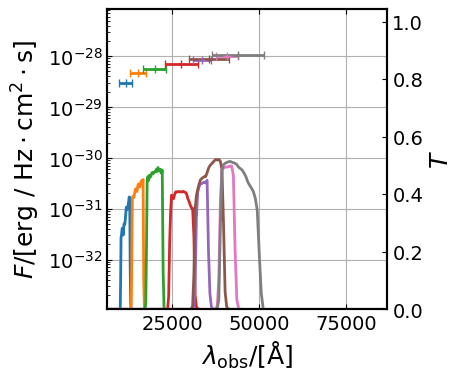

In [23]:
# Get the observed spectrum, using the simulation cosmology and IGM from 
# Inoue+14.
galaxy.get_observed_spectra(cosmo=cosmo, igm=Inoue14)

# Define the filter collection based on the GN-z11 JWST filters.
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F115W', 'F150W','F200W', 'F277W', 'F335M', 'F356W',
                                             'F410M','F444W']]
filters = FilterCollection(filter_codes, new_lam=grid.lam)

# Measure and plot the observed "emergent" fluxes.
fluxes = galaxy.stars.get_photo_fluxes(filters)
fig, ax = galaxy.stars.photo_fluxes["emergent"].plot_photometry(show=True)

After converting the _emergent_ fluxes to $\mu \textrm{Jy}$,  we can calculate a percentage error and add noise by sampling from a normal distribution with mean and deviation defined by the flux and error.

In [24]:
#---------------------------------------
error = 0.05    # Flux percentage error.
#---------------------------------------

# Bagpipes expects fluxes in uJy, lets get an array of these.
bp_fluxes = np.array([float(flux.value) for flux in fluxes["emergent"].photo_fluxes.to('uJy')])

# Generate flux errors.
errors = bp_fluxes*error

# Add gaussian noise to the fluxes based on the error values.
bp_fluxes = np.random.normal(bp_fluxes,errors)

__Task:__ Determine which of Bagpipes' SFH parameterisations best matches that of your chosen galaxy. You can easily plot the SFH of your galaxy using Synthesizer.

We can use the `plot_sfzh` method to visualise the star formation and metallicity history. In the case of the example galaxy, the best parameterisation seems to be an exponential.

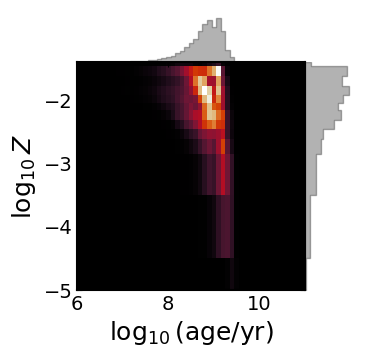

In [25]:
# Plot the SFZH.
fig,ax = galaxy.stars.plot_sfzh(grid)

__Task__: Use Bagpipes to fit the noisy photometry. Use the SFH you determined above, fix the redshift at the true value and choose the other model components appropriately. How well are the true values recovered?

You can fix $\mathrm{logU} = -2$, which is the value used to generate Synthesizer grids.

After defining the list of paths in the same order used to define the filter collection, we can define an appropriate `load_data` function and fit dictionary.

In [26]:
# Paths to filter transmission files.
bp_filters = ["filters/JWST_NIRCam.F115W.dat", "filters/JWST_NIRCam.F150W.dat", 
              "filters/JWST_NIRCam.F200W.dat", "filters/JWST_NIRCam.F277W.dat",
              "filters/JWST_NIRCam.F335M.dat", "filters/JWST_NIRCam.F356W.dat",
              "filters/JWST_NIRCam.F410M.dat", "filters/JWST_NIRCam.F444W.dat"]

# Dummy function for passing fluxes and errors to Bagpipes.
def load_data(ID, bp_fluxes = bp_fluxes, errors = errors):

    photometry = np.c_[bp_fluxes, errors]

    return photometry

In [27]:
fit_info = {}   

# Fixed redshift to true value.
fit_info["redshift"] = snapshot_redshift    

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag] 
fit_info["dust"] = dust

# Assume an exponential SFH.
exponential = {}
exponential["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
exponential["metallicity"] = (1e-4,1)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

# Allow the exponential to be increasing or decreasing.
exponential["tau"] = (-5, 5)     # Timescale of exponential change. [Gyr] 

# We know the redshift, so can set the maximum age accordingly.
exponential["age"] = (0, float(cosmo.age(snapshot_redshift).value))    # Time since SF began. [Gyr]

fit_info['exponential'] = exponential

# Nubular.
nebular = {}
nebular["logU"] = -2    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

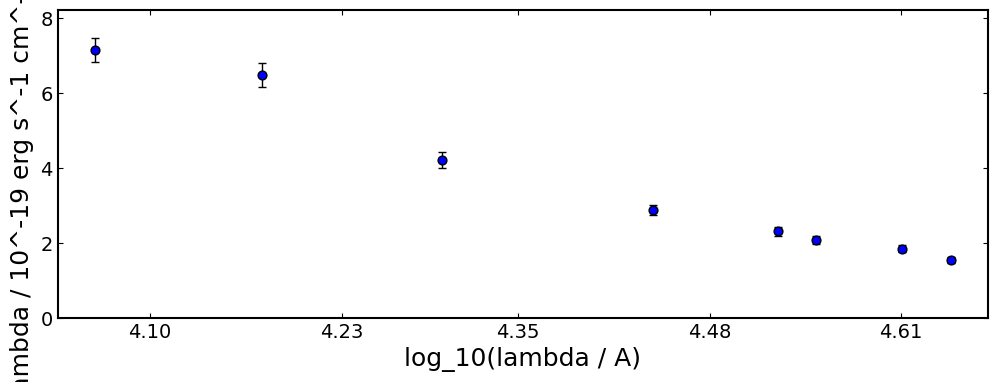

In [28]:
# Create the bagpipes galaxy.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=bp_filters, spectrum_exists=False)
fig = bp_galaxy.plot()

In [29]:
# Fit the model to the noisy photometry.
fit = pipes.fit(bp_galaxy, fit_info, run='forward_model')
fit.fit(verbose=False, sampler=sampler)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

Completed in 25.9 seconds.
 ln(ev)=   341.71584477025215      +/-  0.16360323212488054     
 Total Likelihood Evaluations:        24991
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.632      0.904      1.071
exponential:age                0.249      0.593      2.109
exponential:massformed        10.357     10.548     10.735
exponential:metallicity        0.825      0.918      0.974
exponential:tau               -3.825     -1.554      2.892




At least in this case, the spectrum doesn't look too bad, but the SFH doesn't seem to be falling off as quickly as we saw above. We know the true physical properties so can plot them on the corner plot. The mass is reasonably well recovered, but the dust and metallicity are overestimated, while the age is underestimated.

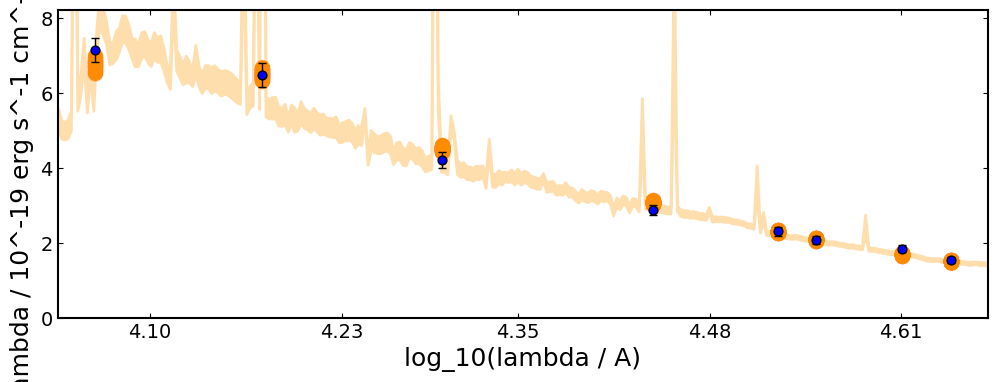

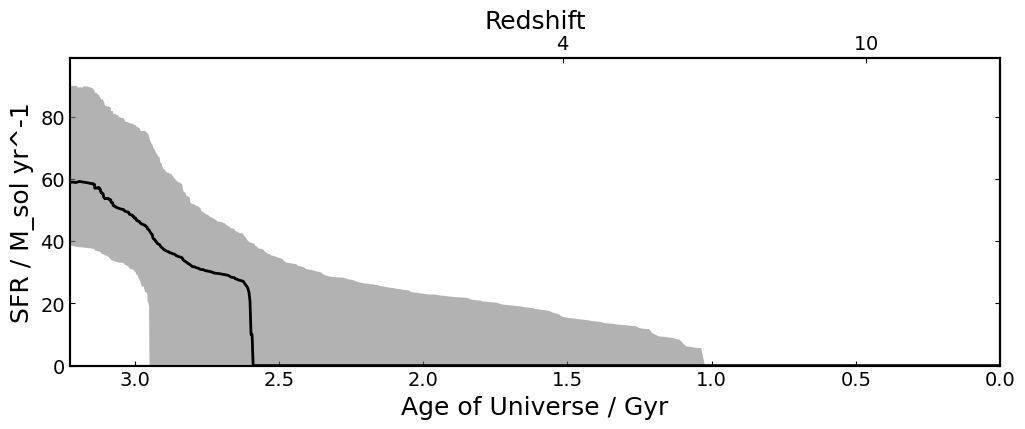

In [30]:
# Can use built in functions to plot SED and SFH.
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)

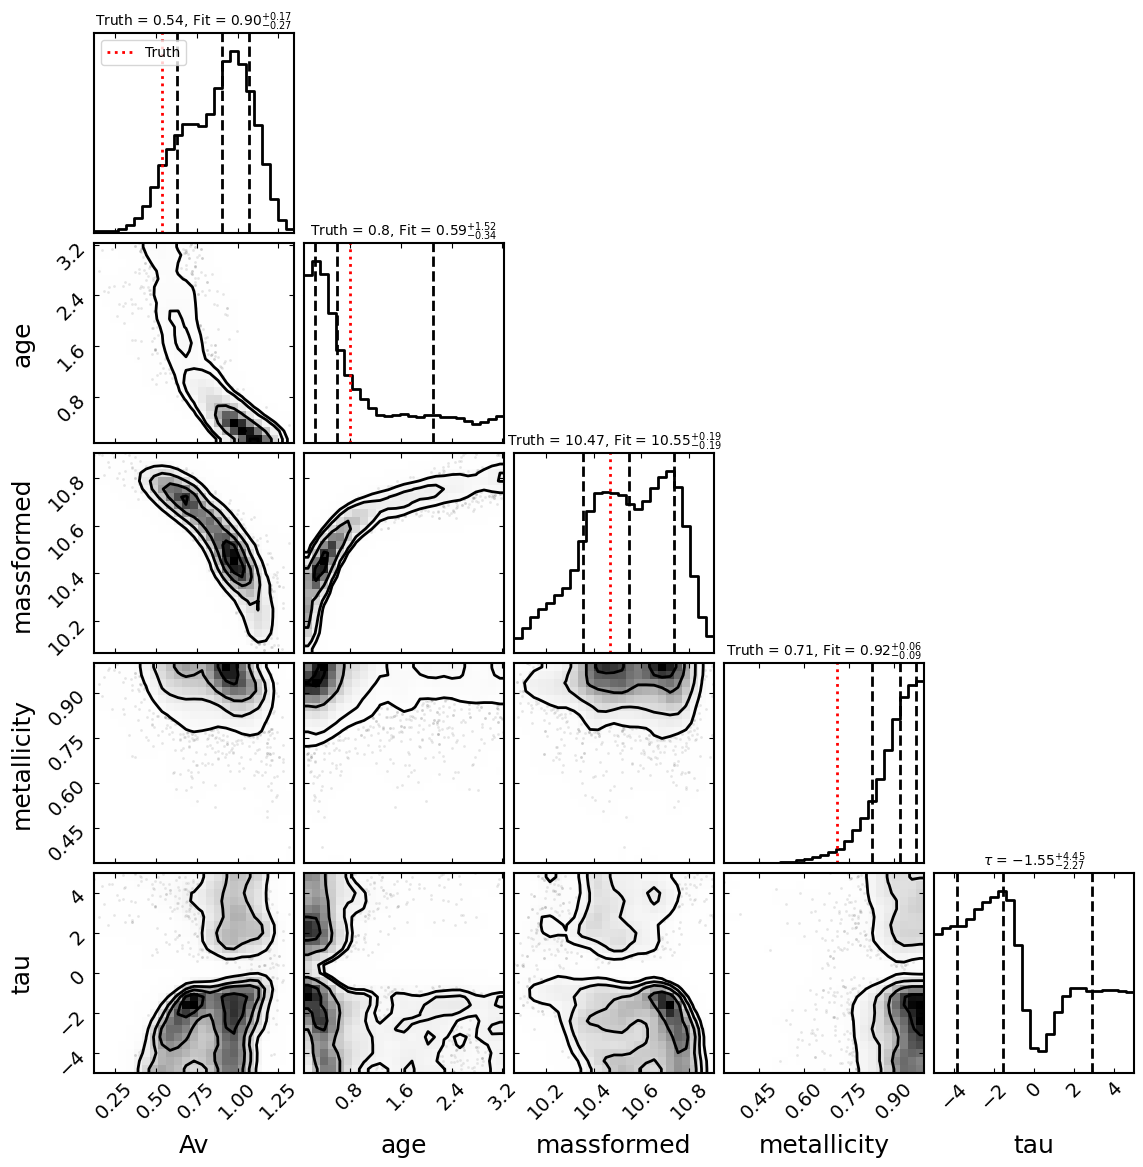

In [31]:
# We know the true values, so can make a corner plot that displays them.

# Get the Bagpipes 2D posteriors.
samples = np.copy(fit.posterior.samples2d)

# Get the true values,
Av = round(tau_v*1.086,2)
mean_age = round(float(np.mean(galaxy.stars.ages).to(Gyr).value), 2)
stellar_mass = round(float(np.log10(np.sum(stars.initial_masses))),2)
metallicity = round(np.mean(galaxy.stars.metallicities)/0.02, 2)

# and create lables based on these values.
truth = [Av,mean_age,stellar_mass,metallicity]
titles = ['Truth = '+str(value)+', Fit' for value in truth] + ['$\\tau$']
labels = [label.split(':')[1] for label in fit.fitted_model.params]

make_corner(samples, truth, labels, titles)

### Bagpipes Performance

---

In [32]:
# We need the parametric functions now.
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer.parametric.galaxy import Galaxy

__Task:__ Investigate the optimal performance of Bagpipes.

Construct a very simple parametric galaxy using

- a [BC03 SPS model grid](https://www.dropbox.com/scl/fo/3n8v3o4m85b0t8fl8pm0n/h?rlkey=9x4cijjnmvw5m6plnyovywuva&e=1&dl=0])

- a constant SFH
- constant metallicity
- dust attenuation and emision

and select the other parameters as you see fit. 

Calculate the flux you would observe from this galaxy in the JWST filters after adding noise. Fit this photometry using a model with matching component choices and fixed redshift. How well are the physical properties recovered in this ideal scenario?

We can start by defining the grid, SFH and metallicity distribution, which can all be done using single functions. We can then use these objects and a stellar mass to create a parametric `Stars` object.

In [33]:
# Load the BC03 age-metallicity grid.
#--------------------------------------------
grid_dir = "../grids"
grid_name = "bc03_chabrier03-0.1,100_cloudy-c17.03.hdf5"
#--------------------------------------------

grid = Grid(grid_name, grid_dir=grid_dir)

In [34]:
# Let's measure photometry in the GN-z11 filters.
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F115W', 'F150W','F200W', 'F277W', 'F335M', 'F356W',
                                             'F410M','F444W']]
filters = FilterCollection(filter_codes, new_lam=grid.lam)

In [35]:
# Generate the stars for our galaxy.

#--------------------------------------------------------------------------
z = 5    # Change the redshift at which the galaxy is observed.

log10z = -2.0    # Change the metalicity.
max_age = (cosmo.age(z).value - cosmo.age(30).value) * Gyr    # Maximum age of stars.
min_age = 0 * Gyr    # Minimum age of stars.
stellar_mass = 1E8    # Change the total stellar mass of stars [M_sol].
#--------------------------------------------------------------------------

# Define a constant metallicity
metal_dist = ZDist.DeltaConstant(log10metallicity=log10z) 

# and a constant SFH.
sfh = SFH.Constant(max_age, min_age)

# Generate the Stars object.
stars = Stars(
    log10ages=grid.log10age,
    metallicities=grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
    )

Now similarlly to the particle case, we can define an emission model, before calaculating the photometric fluxes from the observed spectrum. We can then add noise using the same approach as above. We can then go through the usual fitting procedure.

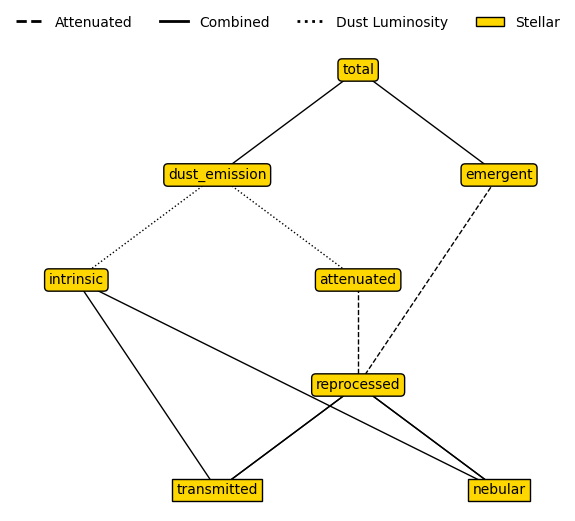

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


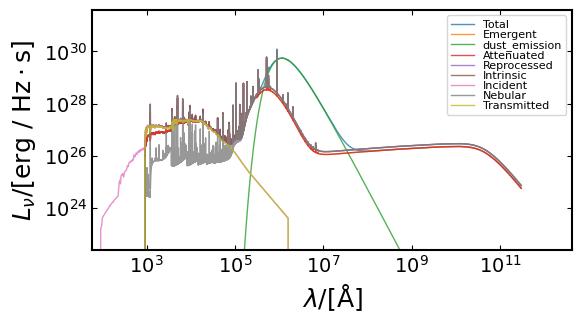

In [36]:
# Get the SED of our galaxy.

#------------------------------------------------------------------
dust_curve = Calzetti2000()    # Chnage the dust attenuation curve.
tau_v = 0.5    # Change the V-band attenuation of the galaxy.
fesc = 0.0   # Change the escape fraction.
fesc_ly_alpha = 1.0    # Chnage the escape fraction of Lyman-alpha.
dust_emission = Greybody(30 * K, 1.2)    # Dust emission model.
#------------------------------------------------------------------

# Create the galaxy from the stars.
galaxy = Galaxy(stars, redshift=z)

# Define the emission model.
emission = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve,
    dust_emission=dust_emission,
    fesc=fesc,
    fesc_ly_alpha=fesc_ly_alpha
    )
emission.plot_emission_tree()

# Generate the spectra,
sed = galaxy.stars.get_spectra(emission)
fig, ax = galaxy.stars.plot_spectra(show=True, figsize=(6, 4))

# and get the observed fluxes.
galaxy.get_observed_spectra(cosmo=cosmo, igm=Inoue14)
fluxes = galaxy.stars.get_photo_fluxes(filters)


In [37]:
# Paths to filter transmission files.
jwst_filters = ["filters/JWST_NIRCam.F115W.dat", "filters/JWST_NIRCam.F150W.dat",
                "filters/JWST_NIRCam.F200W.dat", "filters/JWST_NIRCam.F277W.dat",
                "filters/JWST_NIRCam.F335M.dat", "filters/JWST_NIRCam.F356W.dat",
                "filters/JWST_NIRCam.F410M.dat", "filters/JWST_NIRCam.F444W.dat",
                ]

#---------------------------------------
error = 0.05    # Flux percentage error.
#---------------------------------------

# Bagpipes expects fluxes in uJy, lets get an array of these.
bp_fluxes = np.array([float(flux.value) for flux in fluxes["total"].photo_fluxes.to('uJy')])

# Generate flux errors.
errors = bp_fluxes*error

# Add gaussian noise to the fluxes based on the error values.
bp_fluxes = np.random.normal(bp_fluxes,errors)

# Dummy function for passing fluxes and errors to Bagpipes.
def load_data(ID, bp_fluxes = bp_fluxes, errors = errors):

    photometry = np.c_[bp_fluxes, errors]

    return photometry

In [38]:
fit_info = {}   

# Fixed redshift to true value.
fit_info["redshift"] = z    

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Use a simple constant SFH.
constant = {}
constant["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
constant["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

constant["age_max"] = (0, float(cosmo.age(z).value))      # Time since SF switched on. [Gyr] 
constant["age_min"] = (0, float(cosmo.age(z).value))      # Time since SF switched off. [Gyr]

fit_info['constant'] = constant

# Nubular.
nebular = {}
nebular["logU"] = -2    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

In [39]:
# Create the bagpipes galaxy and fit.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_filters, spectrum_exists=False)

fit = pipes.fit(bp_galaxy, fit_info, run = 'optimal')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the pr

Plotting the results, at least in this case, Bagpipes is recovering most of the measured parameters within $1\sigma$. However, even with a simple optimal setup, the maximum age of stars is not well constrained.

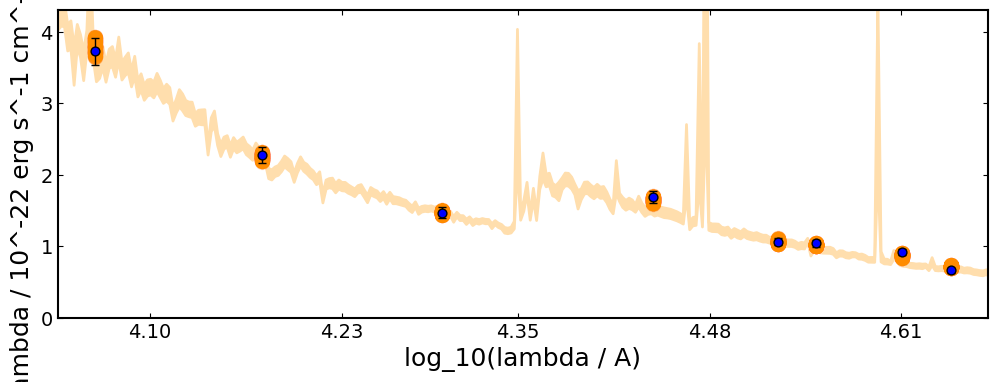

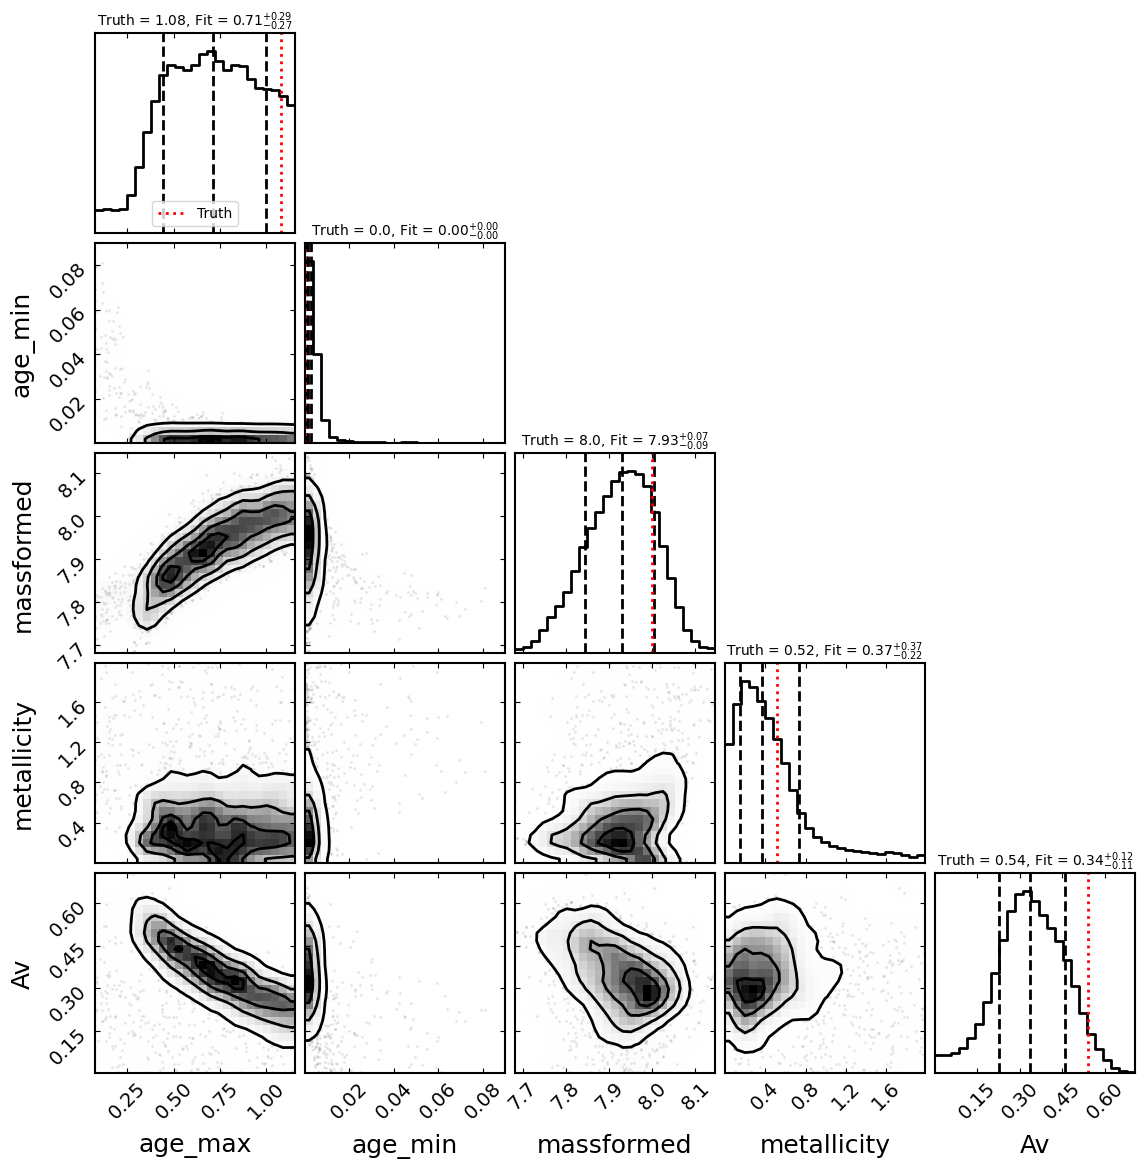

In [40]:
# Plot the spectrum from the fit.
fig = fit.plot_spectrum_posterior(save=False, show=True)

# Get the Bagpipes 2D posteriors.
samples = np.copy(fit.posterior.samples2d)

# Get the true values,
Av = round(tau_v*1.086,2)
metallicity = round(np.mean(galaxy.stars.metallicities)/0.02, 2)

# and create lables based on these values.
truth = [float(max_age.value), float(min_age.value), np.log10(stellar_mass), metallicity, Av]
titles = ['Truth = '+str(round(value,2))+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params]

make_corner(samples, truth, labels, titles)

__Task:__ How does the performance change when the redshift is a free parameter?

We just need to edit the fit instructions, and perform another fit. Remember that we can't put an upper limit on age anymore.

In [41]:
fit_info = {}   

# Fixed redshift to true value.
fit_info["redshift"] = (0,20)    

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag] 
fit_info["dust"] = dust

# Constant SFH.
constant = {}
constant["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
constant["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

constant["age_max"] = (0, float(cosmo.age(0).value))      # Time since SF switched on. [Gyr]
constant["age_min"] = (0, float(cosmo.age(0).value))      # Time since SF switched off. [Gyr]

fit_info['constant'] = constant

# Nubular.
nebular = {}
nebular["logU"] = -2    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

In [42]:
# Fit the model to the measured photometry.
fit = pipes.fit(bp_galaxy, fit_info, run = 'optimal_zfree')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the pr

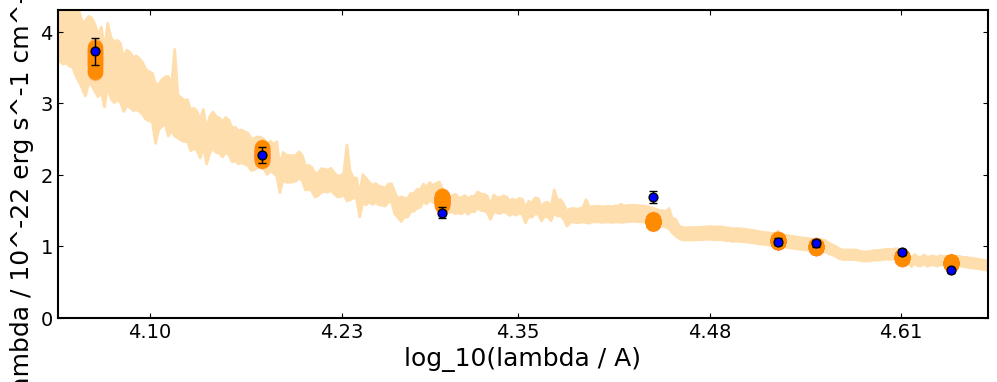

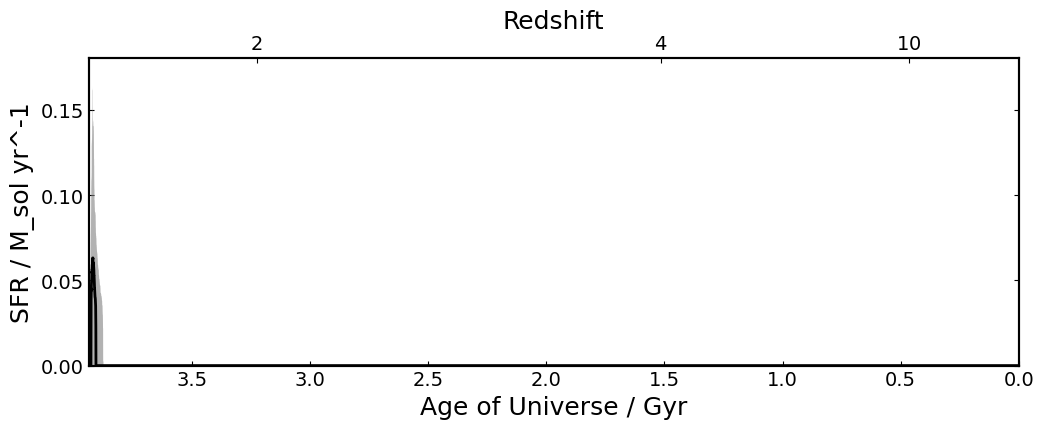

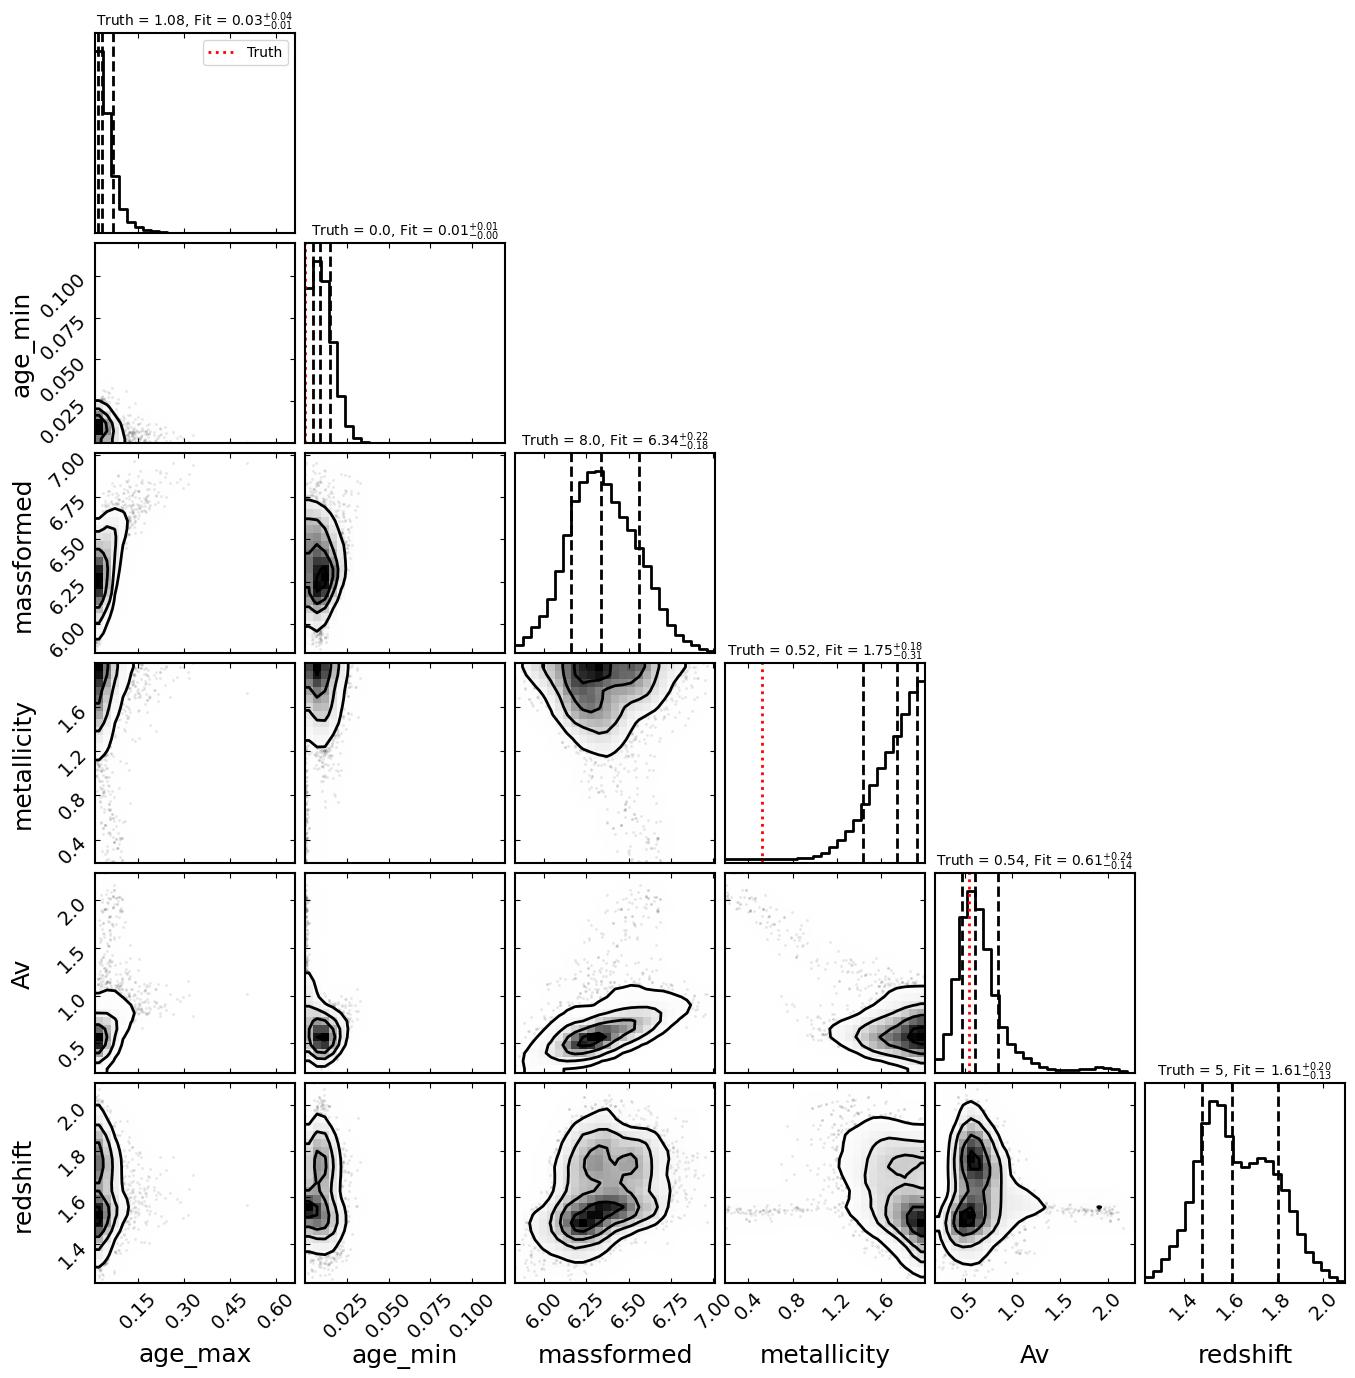

In [43]:
# Plot the spectrum from the fit.
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)

# Get the Bagpipes 2D posteriors.
samples = np.copy(fit.posterior.samples2d)

# Get the true values,
Av = round(tau_v*1.086,2)
metallicity = round(np.mean(galaxy.stars.metallicities)/0.02, 2)

# and create lables based on these values.
truth = [float(max_age.value), float(min_age.value), np.log10(stellar_mass), metallicity, Av, z]
titles = ['Truth = '+str(round(value,2))+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params[:-1]] + ['redshift']

make_corner(samples, truth, labels, titles)

At least in this case, removing the redshift information causes everything to fall apart.

__Task:__ Which modelling choice is the most important?

Try fitting with model components that differ from the true parameterisation. Which modelling choices change the infered properties the most? You can also try generating a galaxy with a different SPS model.

Let's try fitting with a different star formation history. Exponential is often used so let's try that. We will also return to a fixed redshift.

In [44]:
fit_info = {}   

# Fixed redshift to true value.
fit_info["redshift"] = z   

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Assume an exponential SFH.
exponential = {}
exponential["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
exponential["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

exponential["age"] = (0, float(cosmo.age(z).value))      # Time since SF began. [Gyr]
exponential["tau"] = (0, float(cosmo.age(z).value))      # Timescale of exponential change. [Gyr]

fit_info['exponential'] = exponential

# Nubular.
nebular = {}
nebular["logU"] = -2    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

In [45]:
# Fit the model to the measured photometry.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_filters, spectrum_exists=False)

fit = pipes.fit(bp_galaxy, fit_info, run = 'optimal_exp')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

Completed in 19.1 seconds.
 ln(ev)=   405.69253311620389      +/-  0.16020645700959010     
 Total Likelihood Evaluations:        18474
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.145      0.304      0.459
exponential:age                0.360      0.562      0.797
exponential:massformed         7.819      7.920      8.006
exponential:metallicity        0.171      0.450      0.811
exponential:tau                0.460      0.791      1.043




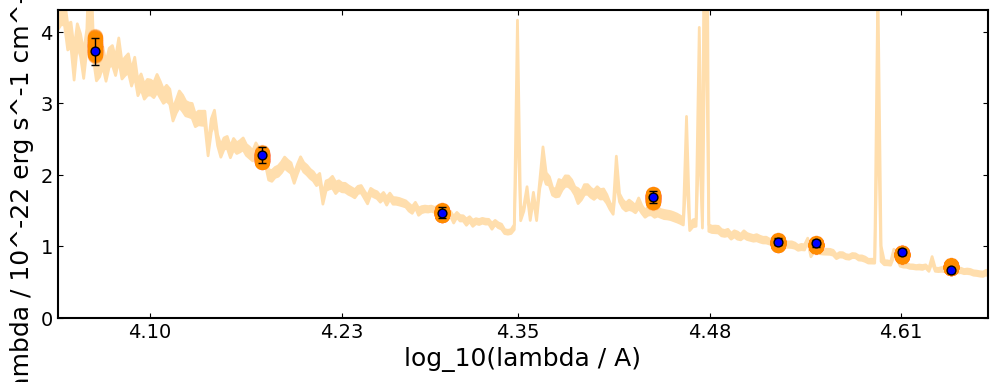

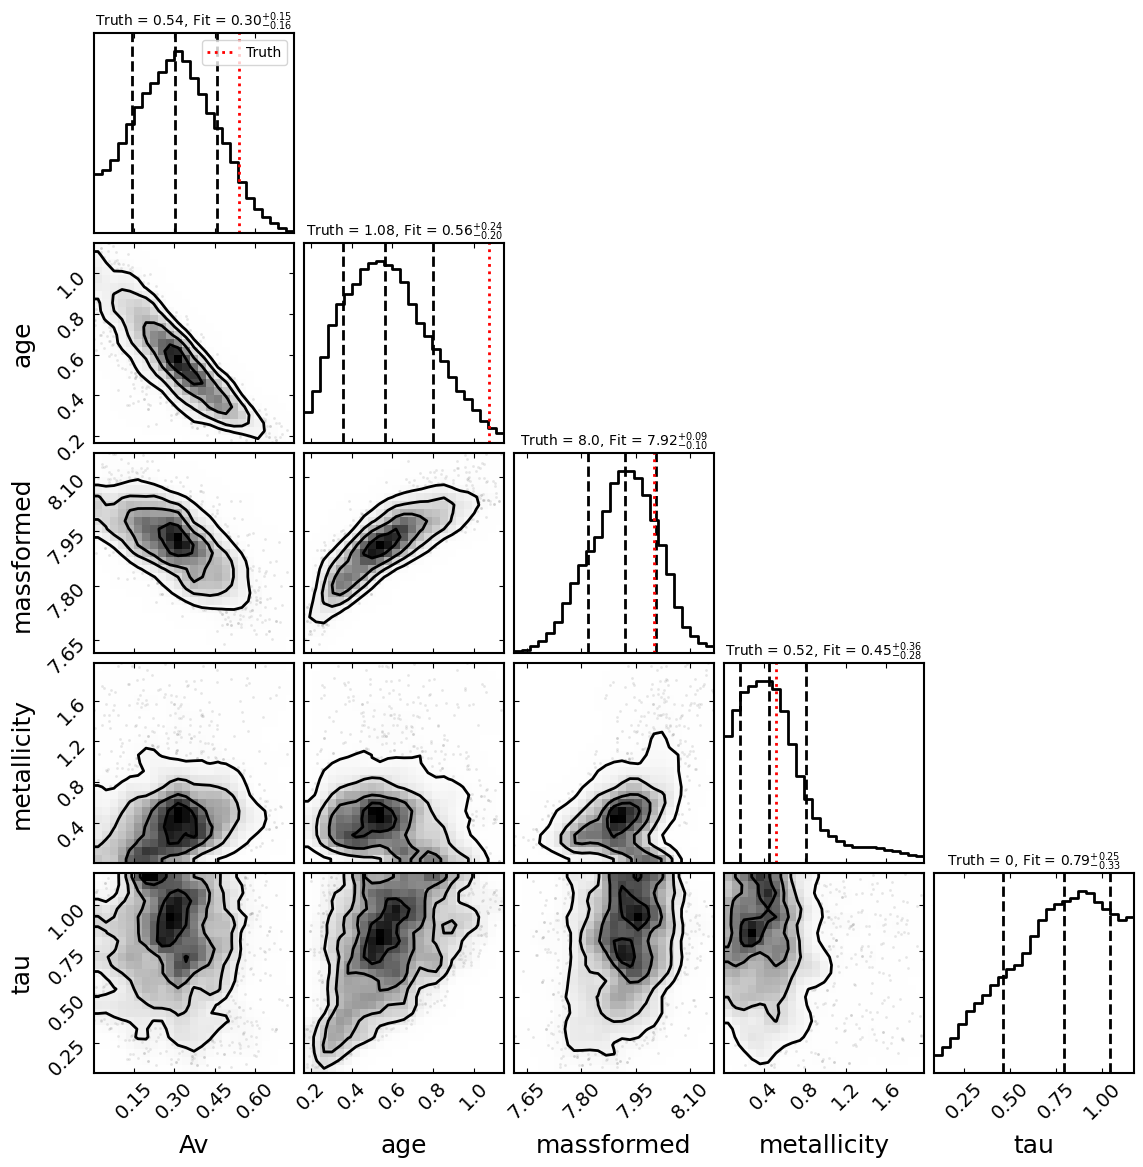

In [46]:
# Plot the spectrum from the fit.
fig = fit.plot_spectrum_posterior(save=False, show=True)

# Get the Bagpipes 2D posteriors.
samples = np.copy(fit.posterior.samples2d)

# Get the true values,
Av = round(tau_v*1.086,2)
metallicity = round(np.mean(galaxy.stars.metallicities)/0.02, 2)

# and create lables based on these values.
truth = [Av, float(max_age.value), np.log10(stellar_mass), metallicity, 0]
titles = ['Truth = '+str(round(value,2))+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params]

make_corner(samples, truth, labels, titles)

Mass and metallicity are still surprisingly well recovered. Prehaps unsurprisingly, considering we are fitting the wrong history, the maximum age of stars is estimated even more poorly than before.

Let's now go back to a constant SFH, but change the assumed dust attenuation law.

In [47]:
fit_info = {}   

# Fixed redshift to true value.
fit_info["redshift"] = z    

# Dust.
dust = {}                         
dust["type"] = "Cardelli"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Use a simple constant SFH.
constant = {}
constant["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
constant["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

constant["age_max"] = (0, float(cosmo.age(z).value))      # Time since SF switched on. [Gyr] 
constant["age_min"] = (0, float(cosmo.age(z).value))      # Time since SF switched off. [Gyr]

fit_info['constant'] = constant

# Nubular.
nebular = {}
nebular["logU"] = -2    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

In [48]:
# Create the bagpipes galaxy.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_filters, spectrum_exists=False)

# Fit the model to the measured photometry.
fit = pipes.fit(bp_galaxy, fit_info, run = 'optimal_cardelli')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the pr

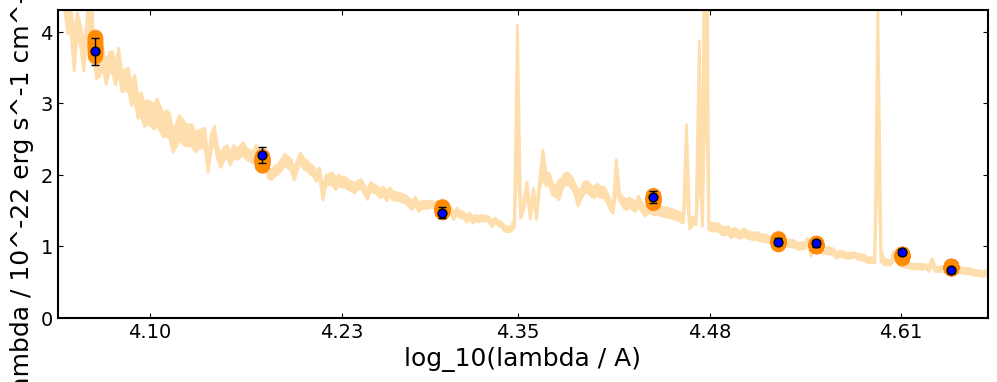

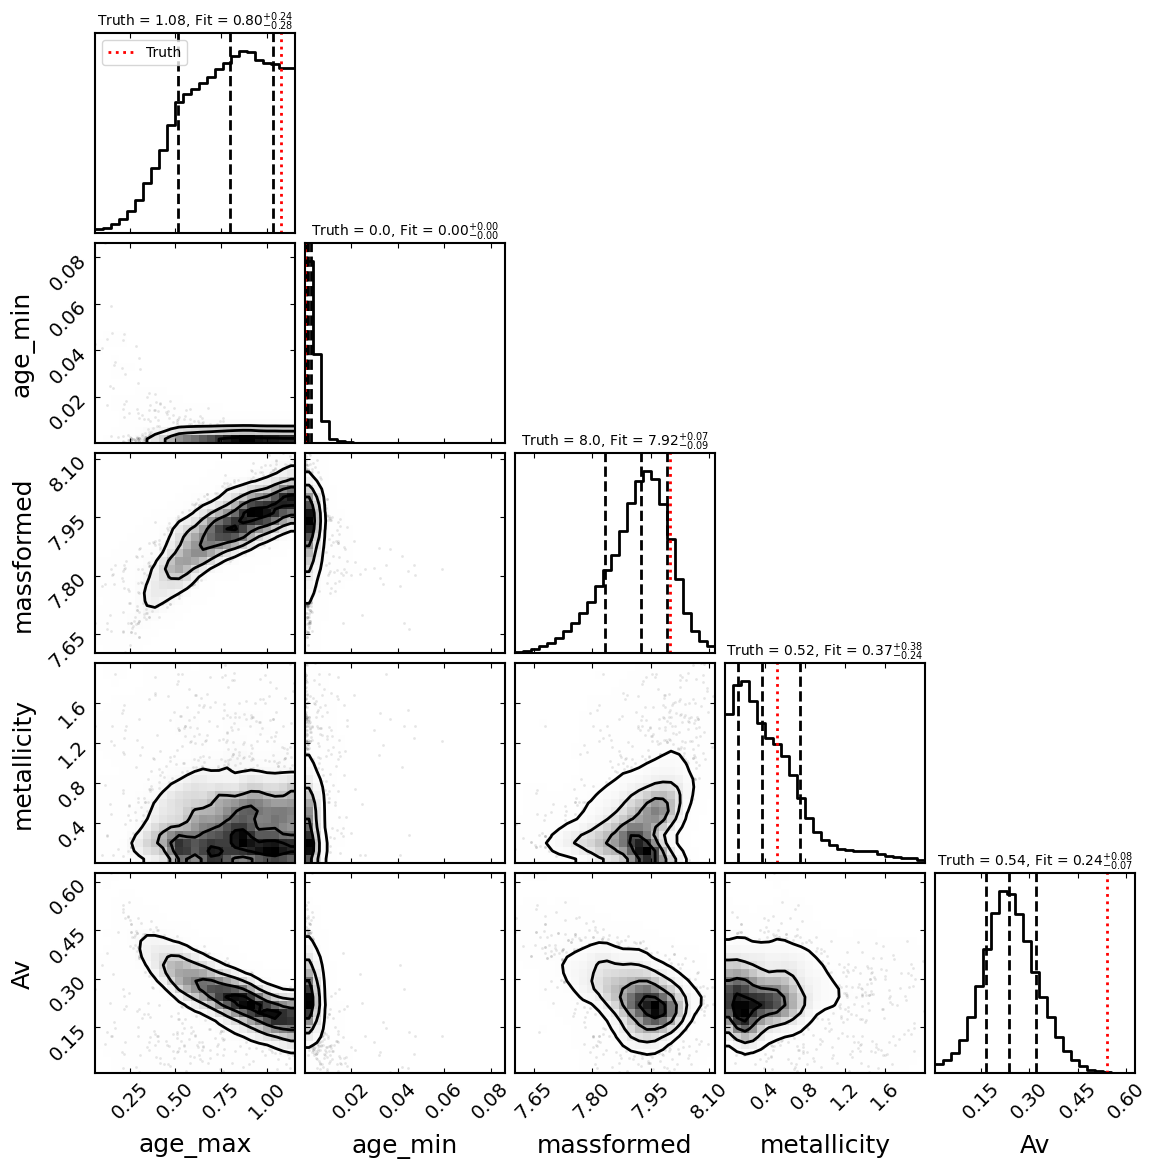

In [49]:
# Plot the spectrum from the fit.
fig = fit.plot_spectrum_posterior(save=False, show=True)

# Get the Bagpipes 2D posteriors.
samples = np.copy(fit.posterior.samples2d)

# Get the true values,
Av = round(tau_v*1.086,2)
metallicity = round(np.mean(galaxy.stars.metallicities)/0.02, 2)

# and create lables based on these values.
truth = [float(max_age.value), float(min_age.value), np.log10(stellar_mass), metallicity, Av]
titles = ['Truth = '+str(round(value,2))+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params]

make_corner(samples, truth, labels, titles)

This doesn't seem to have much of an effect, however the dust is now significantly underestimated.

Finally, let's generate a new galaxy using a BPASS SPS grid.

In [50]:
# Load the a BPASS grid.
#--------------------------------------------
grid_dir = "../grids"
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5"
#--------------------------------------------

grid = Grid(grid_name, grid_dir=grid_dir)

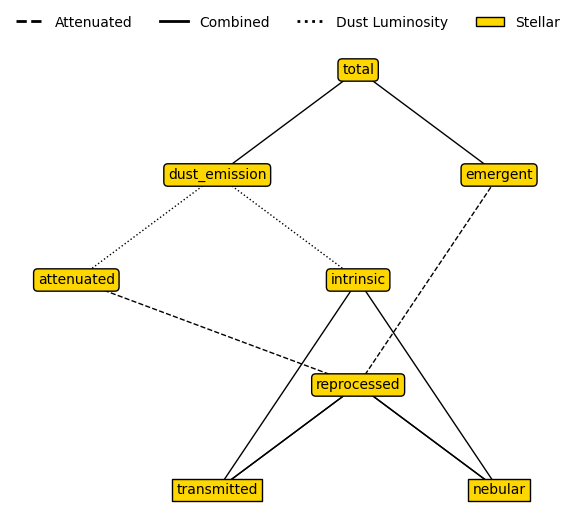

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


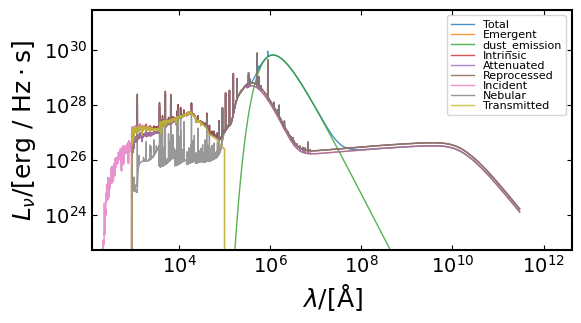

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/synthesizer/components/stellar.py:162: RuntimeWarning: Filter wavelength grid is not the same as the SED wavelength grid.
  ].get_photo_fluxes(filters, verbose)


In [51]:
# Set everything else up in the same way.

# Define a constant metallicity
metal_dist = ZDist.DeltaConstant(log10metallicity=log10z) 

# and a constant SFH.
sfh = SFH.Constant(max_age, min_age)

# Generate the Stars object.
stars = Stars(
    log10ages=grid.log10age,
    metallicities=grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
    )

# Create the galaxy from the stars.
galaxy = Galaxy(stars, redshift=z)

# Define the emission model.
emission = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve,
    dust_emission=dust_emission,
    fesc=fesc,
    fesc_ly_alpha=fesc_ly_alpha
    )
emission.plot_emission_tree()

# Generate the spectra,
sed = galaxy.stars.get_spectra(emission)
fig, ax = galaxy.stars.plot_spectra(show=True, figsize=(6, 4))

# and get the observed fluxes.
galaxy.get_observed_spectra(cosmo=cosmo, igm=Inoue14)
fluxes = galaxy.stars.get_photo_fluxes(filters)

In [52]:
# Bagpipes expects fluxes in uJy, lets get an array of these.
bp_fluxes = np.array([float(flux.value) for flux in fluxes["total"].photo_fluxes.to('uJy')])

# Generate flux errors.
errors = bp_fluxes*error

# Add gaussian noise to the fluxes based on the error values.
bp_fluxes = np.random.normal(bp_fluxes,errors)

# Paths to filter transmission files.
jwst_filters = ["filters/JWST_NIRCam.F115W.dat", "filters/JWST_NIRCam.F150W.dat",
                "filters/JWST_NIRCam.F200W.dat", "filters/JWST_NIRCam.F277W.dat",
                "filters/JWST_NIRCam.F335M.dat", "filters/JWST_NIRCam.F356W.dat",
                "filters/JWST_NIRCam.F410M.dat", "filters/JWST_NIRCam.F444W.dat",
                ]

# Dummy function for passing fluxes and errors to Bagpipes.
def load_data(ID, bp_fluxes = bp_fluxes, errors = errors):

    photometry = np.c_[bp_fluxes, errors]

    return photometry

In [53]:
fit_info = {}   

# Fixed redshift to true value.
fit_info["redshift"] = z    

# Dust.
dust = {}                         
dust["type"] = "Cardelli"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Use a simple constant SFH.
constant = {}
constant["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
constant["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

constant["age_max"] = (0, float(cosmo.age(z).value))      # Time since SF switched on. [Gyr] 
constant["age_min"] = (0, float(cosmo.age(z).value))      # Time since SF switched off. [Gyr]

fit_info['constant'] = constant

# Nubular.
nebular = {}
nebular["logU"] = -2    # Log of the ionization parameter. 

fit_info["nebular"] = nebular

In [54]:
# Create the bagpipes galaxy and fit.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_filters, spectrum_exists=False)

fit = pipes.fit(bp_galaxy, fit_info, run = 'optimal_bpass')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the pr

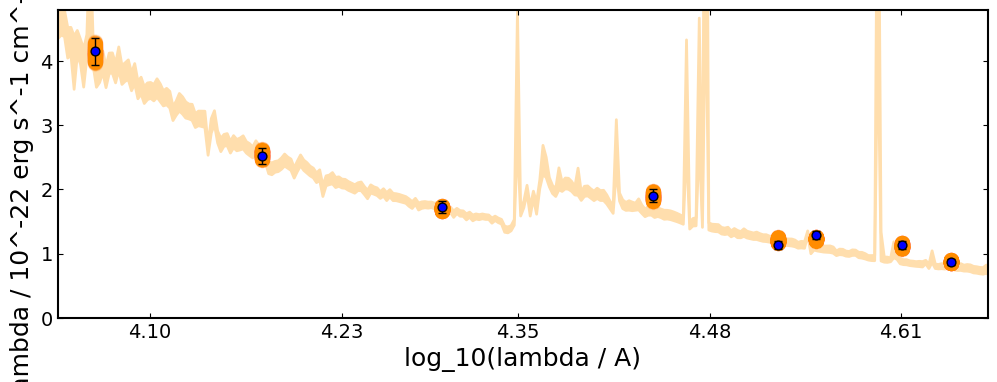

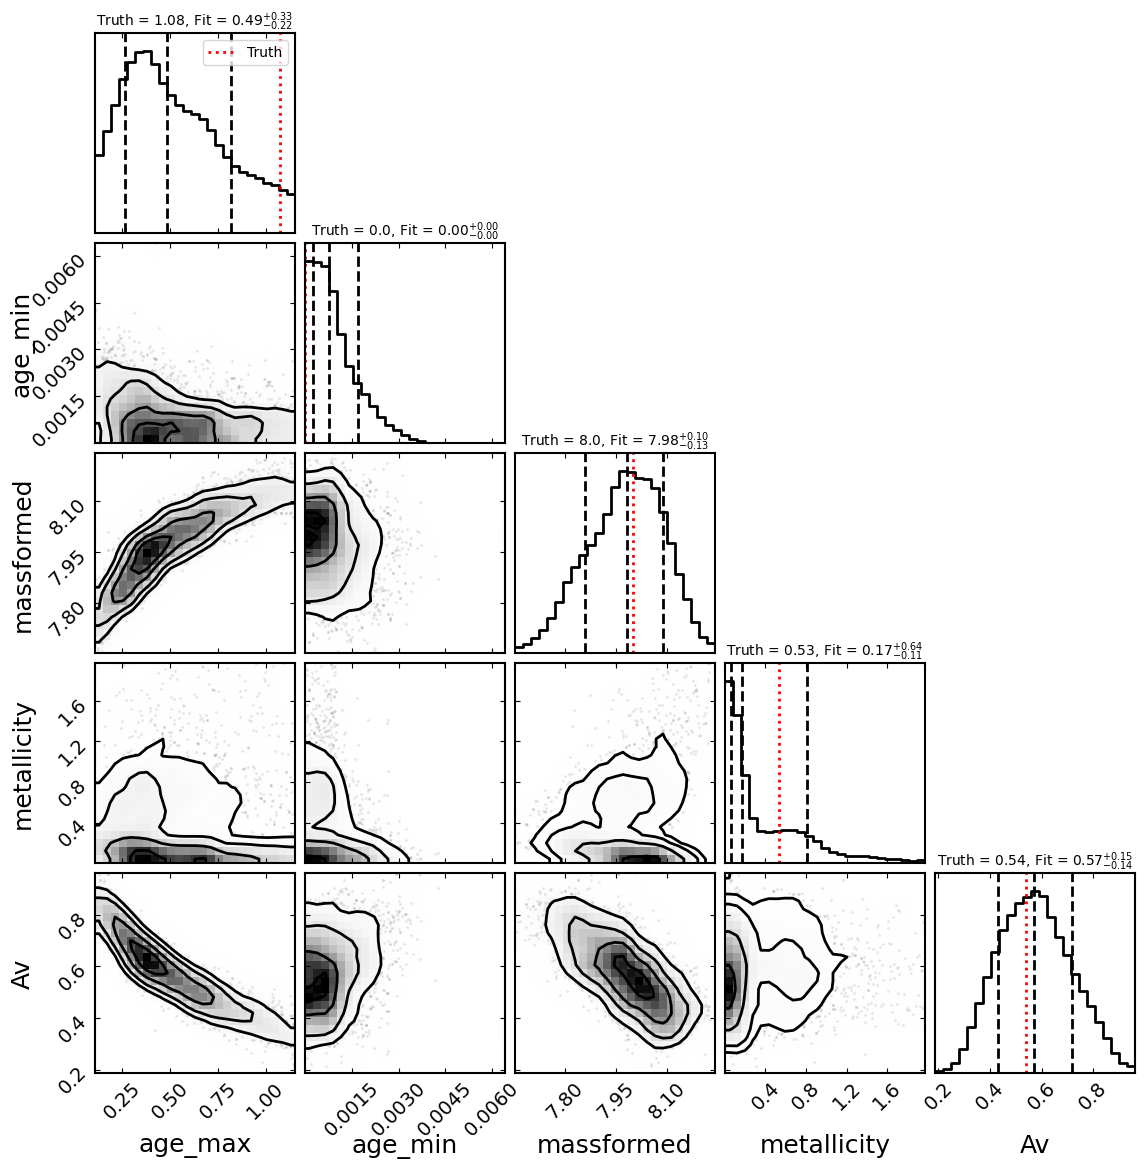

In [55]:
# Plot the spectrum from the fit.
fig = fit.plot_spectrum_posterior(save=False, show=True)

# Get the Bagpipes 2D posteriors.
samples = np.copy(fit.posterior.samples2d)

# Get the true values,
Av = round(tau_v*1.086,2)
metallicity = round(np.mean(galaxy.stars.metallicities)/0.02, 2)

# and create lables based on these values.
truth = [float(max_age.value), float(min_age.value), np.log10(stellar_mass), metallicity, Av]
titles = ['Truth = '+str(round(value,2))+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params]

make_corner(samples, truth, labels, titles)